In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator

DATA_DIR = 'data'

**Research question:**

## Task 1: Data Preprocessing

In [60]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]

# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")

user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Compute the median of gap_days per user
user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median()
).reset_index(drop=True)

# Add the number of activities of that user (count)
user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

# Drop the original timedelta column
user_activity.drop(columns=['median_activity_duration'], inplace=True)

print("Activity per User:")
display(user_activity.head())
print("Shape:", user_activity.shape)



Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_18980/2398963956.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


New preprocessing starts here

In [61]:
# TODO: Monter ceci avant la creation de user_activity

# Remove outliers in activity_started with IQR method
print("Length before removing outliers in activity_started:", activity.shape[0])
Q1 = activity['activity_started'].quantile(0.25)
Q3 = activity['activity_started'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
activity = activity[
    (activity['activity_started'] >= lower_bound) &
    (activity['activity_started'] <= upper_bound)
]
print("Length after removing outliers in activity_started:", activity.shape[0])

Length before removing outliers in activity_started: 22754
Length after removing outliers in activity_started: 21803


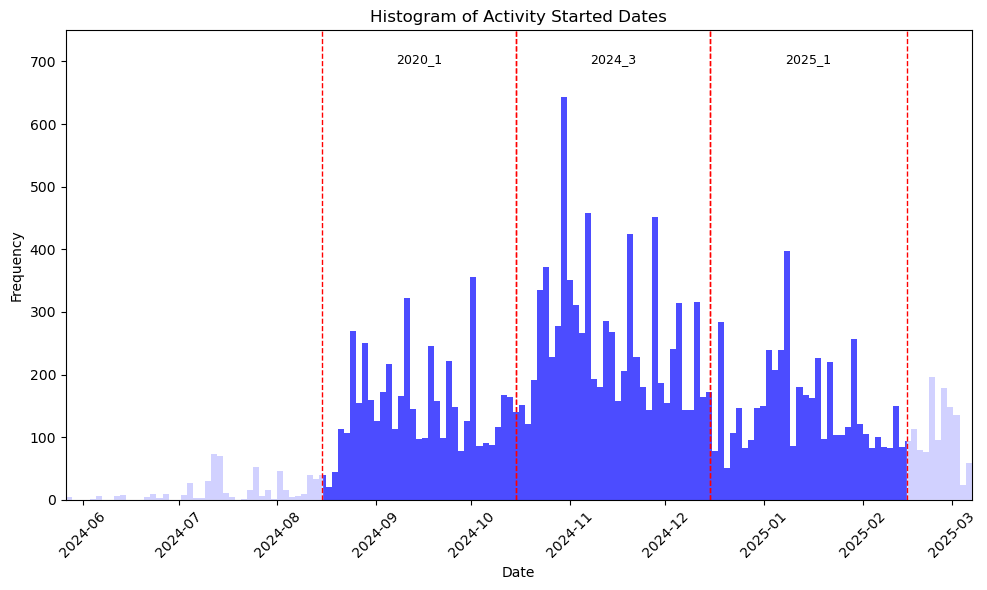

In [69]:
# Define your dynamic periods
periods = [
    ('2024-08-15', '2024-10-15', '2020_1'),
    ('2024-10-15', '2024-12-15', '2024_3'),
    ('2024-12-15', '2025-02-15', '2025_1'),
    # ('2025-02-15', '2025-04-15', '2025_2'),
    # Add more periods here without modifying any code below
]

# Prepare histogram data
min_date = activity['activity_started'].min()
max_date = activity['activity_started'].max()

# Plot histogram with explicit range starting from min_date
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(activity['activity_started'], bins=150, color='blue', alpha=0.7, range=(min_date, max_date))

# Slightly shorten bars to leave space for text labels
for patch in patches:
    patch.set_height(patch.get_height() * 0.9)

# Convert period boundaries to timestamps
period_bounds = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end, _ in periods]
first_start = period_bounds[0][0]
last_end = period_bounds[-1][1]

# Shade before first and after last period
color, alpha = 'white', 0.75
if min_date < first_start:
    plt.axvspan(min_date, first_start, color=color, alpha=alpha)
if max_date > last_end:
    plt.axvspan(last_end, max_date, color=color, alpha=alpha)

# Add vertical dashed lines and period labels
for (start_ts, end_ts), (_, _, period_name) in zip(period_bounds, periods):
    midpoint = start_ts + (end_ts - start_ts) / 2
    plt.axvline(start_ts, color='red', linestyle='--', linewidth=1)
    plt.axvline(end_ts, color='red', linestyle='--', linewidth=1)

    # Add period name slightly above shortened bars
    plt.text(midpoint, max(counts), period_name,
             ha='center', va='top', fontsize=9, color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Histogram of Activity Started Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlim(min_date, max_date)
plt.tight_layout()
plt.show()



In [82]:
def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.

    Parameters:
    -----------
    activity_df : pandas DataFrame
        The original activity dataframe.
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods.

    Returns:
    --------
    dict
        Dictionary of user_activity dataframes for each period.
    """
    user_activity_periods = {}

    for start_date, end_date, period_name in periods:
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) &
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)

        if period_activity.empty:
            continue

        user_daily_activity = period_activity.copy()
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        duration_median = (period_activity['activity_completed'] - period_activity['activity_started']).groupby(period_activity['user_id']).median()

        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        user_activity['period'] = period_name

        user_activity_periods[period_name] = user_activity

    return user_activity_periods

# Create the period user activity dict
user_activity_periods = create_user_activity_by_period(activity, periods)

# Concatenate all into one dataframe dynamically
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nUser activity across all periods:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")
print("\n")

# Number of unique users in each period
for period_name, user_activity_df in user_activity_periods.items():
    unique_users = user_activity_df['user_id'].nunique()
    print(f"Unique users in {period_name}: {unique_users}")
print("\n")

# Continous periods pairs
period_pairs = []
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    period_pairs.append((period1, period2))
    
# Number of unique users in pairs of periods
for period1, period2 in period_pairs:
    users_period1 = user_activity_periods[period1]['user_id'].unique()
    users_period2 = user_activity_periods[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,128,NaN,1,6,2,1.525000,2020_1
1,129,NaN,1,1,1,1.850000,2020_1
2,130,NaN,1,66,4,0.375000,2020_1
3,131,NaN,1,11,2,0.600000,2020_1
4,142,NaN,1,9,2,6.483333,2020_1


Shape: (1409, 7)


Unique users in 2020_1: 427
Unique users in 2024_3: 565
Unique users in 2025_1: 417


Common users between 2020_1 and 2024_3: 314
Common users between 2024_3 and 2025_1: 310


### B) Student Scores (Target):

In [83]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

In [84]:
def compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods):
    """
    Computes median scores per user for each period and merges with corresponding user_activity.
    
    Parameters:
    -----------
    all_scores : pandas DataFrame
        DataFrame containing all user scores
    user_activity_periods : dict
        Dictionary of user_activity dataframes for each period
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods
    
    Returns:
    --------
    dict
        Dictionary of merged student dataframes for each period
    """
    students_by_period = {}
    
    for start_date, end_date, period_name in periods:        
        period_scores = all_scores[
            (all_scores['time'] >= pd.Timestamp(start_date)) & 
            (all_scores['time'] < pd.Timestamp(end_date))
        ].copy()

        if period_scores.empty:
            continue
        
        user_activity = user_activity_periods.get(period_name)
        if user_activity is None or user_activity.empty:
            continue

        students_median_score = period_scores.groupby('user_id')['percentage'].median().reset_index()
        students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
        students_median_score['scores_count'] = period_scores.groupby('user_id')['percentage'].count().values

        # Filter out users with only one score
        students_median_score_filtered = students_median_score[students_median_score['scores_count'] > 1]
        # print(f"Users with at least 2 scores in {period_name}: {len(students_median_score_filtered)}")

        # IQR-based outlier removal
        Q1 = students_median_score_filtered['scores_count'].quantile(0.25)
        Q3 = students_median_score_filtered['scores_count'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        length_before = len(students_median_score_filtered)
        students_median_score_filtered = students_median_score_filtered[
            (students_median_score_filtered['scores_count'] >= lower_bound) & 
            (students_median_score_filtered['scores_count'] <= upper_bound)
        ]
        length_after = len(students_median_score_filtered)

        # print(f"Number of users before outlier removal: {length_before}")
        # print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

        # Filter period_scores to retain users only
        period_scores_filtered = period_scores[period_scores['user_id'].isin(students_median_score_filtered['user_id'])]

        students = user_activity.merge(
            students_median_score_filtered,
            how='inner',
            on='user_id'
        )
        students['period'] = period_name

        # print(f"Number of users in user_activity: {user_activity['user_id'].nunique()}")
        # print(f"Number of users in filtered scores: {students_median_score_filtered['user_id'].nunique()}")
        # print(f"Number of users after merge: {students['user_id'].nunique()}")
        
        students_by_period[period_name] = students

    return students_by_period

# Compute and merge scores
students_by_period = compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods)

# Combine all periods into one dataframe
all_students = pd.concat(students_by_period.values(), ignore_index=True)
print("\nUser activity and scores across all periods:")
display(all_students.head())
print(f"Shape: {all_students.shape}")
print("\n")

# Analyze user counts per period
for period_name, df in students_by_period.items():
    print(f"Period {period_name}: {df['user_id'].nunique()} unique users")
print("\n")

# Analyze overlap across periods
if len(students_by_period) > 1:
    user_period_counts = all_students.groupby('user_id')['period'].nunique()
    for i in range(1, len(periods) + 1):
        users_in_n_periods = user_period_counts[user_period_counts == i].count()
        print(f"Users appearing in exactly {i} periods: {users_in_n_periods}")
print("\n")

# Number of unique users in pairs of periods
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    users_period1 = students_by_period[period1]['user_id'].unique()
    users_period2 = students_by_period[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity and scores across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,433,8.5,3,20,3,2.208333,2020_1,75.000,3
1,436,5.5,5,25,3,5.050000,2020_1,70.140,2
2,465,3.5,5,34,3,1.866667,2020_1,95.000,2
3,475,3.0,6,15,2,12.766667,2020_1,88.750,2
4,3112,7.0,4,6,2,1.850000,2020_1,33.335,2


Shape: (641, 9)


Period 2020_1: 119 unique users
Period 2024_3: 329 unique users
Period 2025_1: 193 unique users


Users appearing in exactly 1 periods: 219
Users appearing in exactly 2 periods: 130
Users appearing in exactly 3 periods: 54


Common users between 2020_1 and 2024_3: 93
Common users between 2024_3 and 2025_1: 141


## Task 2: Model Building

Train a model for your research question. 

### A) Profiles Creation (Student Clustering):

We will create clusters of students to better understand the different learner profiles. To achieve this, we will use an unsupervised learning approach with K-Means clustering.

The key hyperparameters we will determine are:

- **Features used for clustering:** Determined through correlation analysis and machine learning coefficient interpretation.
- **Number of clusters (K):** Determined using the Elbow method  

##### 1) Hyperparameter Tuning of Clustering Features:

**Approach:**

- **Corralation Analysis:** As observed in Task A.C, the scores follow a Gaussian distribution. However, the input features are highly right-skewed and appear to follow an exponential distribution. Therefore, we will use Spearman correlation instead of Pearson, as the latter is only appropriate for normally distributed data.

- **Machine Learning Coefficient Interpretation:** We will use a linear regression model to interpret the coefficients and understand which features are most strongly associated with the target. Since the goal is interpretation rather than prediction, we will train the model on the full dataset without splitting it into training and evaluation sets. However, to ensure robustness, we will perform cross-validation and average the coefficient weights across folds.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def cluster_students_by_period(students_by_period, k=4):
    """
    Applies KMeans clustering to students from each period separately.
    
    Parameters:
    -----------
    students_by_period : dict
        Dictionary of student dataframes for each period
    k : int, default=4
        Number of clusters to use
    
    Returns:
    --------
    dict
        Dictionary of clustered student dataframes for each period
    """
    # Features used for clustering
    columns_used = [
        'median_gap_days',
        'active_days_count',
        'activities_count',
        'activity_types_count',
        'median_activity_duration_minutes'
    ]
    
    clustered_students = {}
    cluster_summaries = {}
    
    for period_name, df in students_by_period.items():
        print(f"\n--- Clustering Students for {period_name} ---")
        
        if df is None or len(df) == 0:
            print(f"No data for {period_name}, skipping...")
            continue
            
        # Clean the data - remove rows with NaN in any of the columns used for clustering
        students_no_nan = df.dropna(subset=columns_used)
        print(f"Students after removing NaN: {len(students_no_nan)} (removed {len(df) - len(students_no_nan)} rows)")
        
        if len(students_no_nan) < k:
            print(f"Not enough data points for {period_name} to perform clustering with k={k}, skipping...")
            continue
        
        # Extract features for clustering
        X = students_no_nan[columns_used]
        
        # Normalize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply KMeans with specified K
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        students_no_nan = students_no_nan.copy()
        students_no_nan['cluster'] = kmeans.fit_predict(X_scaled)
        
        # Create visualizations
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Apply PCA to reduce to 2D for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Add PCA components to the DataFrame
        students_projection_pca = students_no_nan.copy()
        students_projection_pca['PCA1'] = X_pca[:, 0]
        students_projection_pca['PCA2'] = X_pca[:, 1]
        
        # Plot Cluster scatterplot using PCA components
        sns.scatterplot(
            data=students_projection_pca,
            x='PCA1',
            y='PCA2',
            hue='cluster',
            palette='tab10',
            ax=ax
        )
        ax.set_title(f"KMeans Clustering for {period_name} (PCA Projection, K={k})")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.legend(title='Cluster')
        ax.grid(True)
        
        plt.tight_layout()
        # plt.show()
        
        # Median feature values per cluster
        cluster_values = students_no_nan.groupby('cluster')[columns_used].median().T
        
        # Compute median score and user count per cluster
        cluster_score_raw = students_no_nan.groupby('cluster').agg(
            median_score=('median_score', 'median'),
            users_count=('user_id', 'nunique')
        )
        
        # Sort clusters by decreasing median_score
        sorted_clusters = cluster_score_raw.sort_values(by='median_score', ascending=False).index.tolist()
        cluster_values = cluster_values[sorted_clusters]
        cluster_score = cluster_score_raw.loc[sorted_clusters].T
        
        # Rename columns to "Cluster 1", "Cluster 2", etc.
        new_columns = [f'Cluster {i+1}' for i in range(len(sorted_clusters))]
        cluster_values.columns = new_columns
        cluster_score.columns = new_columns
        
        # Combine values + scores
        cluster_values_df = pd.concat([cluster_values, cluster_score], axis=0)
        
        print(f"\nCluster Summary for {period_name} (sorted by median score):")
        display(cluster_values_df)
        
        # Update cluster labels in the dataframe based on sorted order
        cluster_mapping = {old_cluster: i for i, old_cluster in enumerate(sorted_clusters)}
        students_no_nan['sorted_cluster'] = students_no_nan['cluster'].map(cluster_mapping)
        students_no_nan['cluster_name'] = 'Cluster ' + (students_no_nan['sorted_cluster'] + 1).astype(str)
        
        # Store results
        clustered_students[period_name] = students_no_nan
        cluster_summaries[period_name] = cluster_values_df
        
        # Show distribution of students across clusters
        plt.figure(figsize=(10, 6))
        cluster_counts = students_no_nan['cluster_name'].value_counts().sort_index()
        ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
        plt.title(f"Number of Students per Cluster - {period_name}")
        plt.xlabel("Cluster")
        plt.ylabel("Number of Students")
        plt.grid(axis='y')
        
        # Add count labels on top of bars
        for i, count in enumerate(cluster_counts.values):
            ax.text(i, count + 5, str(count), ha='center')
            
        # Add percentage labels inside bars
        total = cluster_counts.sum()
        for i, count in enumerate(cluster_counts.values):
            percentage = count / total * 100
            ax.text(i, count/2, f"{percentage:.1f}%", ha='center', color='white', fontweight='bold')
        
        plt.tight_layout()
        # plt.show()
        
    # Compare cluster characteristics across periods
    if len(cluster_summaries) > 1:
        print("\n--- Comparing Cluster Characteristics Across Periods ---")
        
        # For each cluster number, compare its characteristics across periods
        max_clusters = max(len(summary.columns) for summary in cluster_summaries.values())
        
        for cluster_num in range(1, max_clusters + 1):
            cluster_name = f'Cluster {cluster_num}'
            
            # Check which periods have this cluster
            periods_with_cluster = [period for period, summary in cluster_summaries.items() 
                                    if cluster_name in summary.columns]
            
            if len(periods_with_cluster) > 1:
                # Create comparison dataframe
                comparison_data = {}
                for period in periods_with_cluster:
                    comparison_data[period] = cluster_summaries[period][cluster_name]
                
                comparison_df = pd.DataFrame(comparison_data)
                
                print(f"\nComparison of {cluster_name} across periods:")
                display(comparison_df)
    
    return clustered_students, cluster_summaries

# Apply clustering to each period with k=4
clustered_students_by_period, cluster_summaries_by_period = cluster_students_by_period(students_by_period, k=4)

# Optional: Analyze how users transition between clusters across periods
if len(clustered_students_by_period) > 1:
    print("\n--- Analyzing User Transitions Between Clusters Across Periods ---")
    
    # Get all periods in chronological order
    periods = sorted(clustered_students_by_period.keys())
    
    for i in range(len(periods) - 1):
        current_period = periods[i]
        next_period = periods[i+1]
        
        # Get users present in both periods
        current_df = clustered_students_by_period[current_period]
        next_df = clustered_students_by_period[next_period]
        
        common_users = set(current_df['user_id']) & set(next_df['user_id'])
        
        if len(common_users) > 0:
            print(f"\nTransitions from {current_period} to {next_period} ({len(common_users)} users)")
            
            # Create transition dataframe
            current_clusters = current_df[current_df['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
            next_clusters = next_df[next_df['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
            
            transitions = pd.DataFrame({
                'cluster_' + current_period: current_clusters,
                'cluster_' + next_period: next_clusters
            })
            
            # Create transition matrix
            transition_counts = transitions.groupby(['cluster_' + current_period, 'cluster_' + next_period]).size().unstack(fill_value=0)
            
            # Convert to percentages (rows sum to 100%)
            transition_percentages = transition_counts.div(transition_counts.sum(axis=1), axis=0) * 100
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(transition_percentages, annot=True, cmap='YlGnBu', fmt='.1f')
            plt.title(f"Cluster Transitions from {current_period} to {next_period} (%)")
            plt.tight_layout()
            # plt.show()
            
            # Also show raw counts
            plt.figure(figsize=(10, 8))
            sns.heatmap(transition_counts, annot=True, cmap='YlGnBu', fmt='d')
            plt.title(f"Cluster Transitions from {current_period} to {next_period} (counts)")
            plt.tight_layout()
            # plt.show()

In [ ]:
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors

label_list = []
label_index = {}
label_counter = 0
source = []
target = []
value = []
link_colors = []

# Store positions and period groups
x_positions = {}
label_to_period = {}
period_to_labels = {}

# Step 1: Assign x positions and gather clusters per period
periods = sorted(clustered_students_by_period.keys())
n_periods = len(periods)

for i, period_name in enumerate(periods):
    df = clustered_students_by_period.get(period_name)
    if df is not None and len(df) > 0:
        clusters = sorted(df['cluster_name'].unique())
        period_to_labels[period_name] = []
        x = i / (n_periods - 1) if n_periods > 1 else 0.5
        for cluster in clusters:
            short_label = cluster
            unique_label = short_label + f"__{period_name}"
            label_to_period[unique_label] = period_name
            period_to_labels[period_name].append(unique_label)
            label_index[unique_label] = label_counter
            label_list.append(short_label)
            x_positions[label_counter] = x
            label_counter += 1

# Get a colormap (e.g., tab20)
colormap = cm.get_cmap('tab20', 20)

# Step 2: Create transition links with color
transition_id = 0
for i in range(len(periods) - 1):
    p1 = periods[i]
    p2 = periods[i + 1]
    
    df1 = clustered_students_by_period[p1]
    df2 = clustered_students_by_period[p2]
    
    common_users = set(df1['user_id']) & set(df2['user_id'])
    if len(common_users) == 0:
        continue
    
    df1_clusters = df1[df1['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
    df2_clusters = df2[df2['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
    
    transitions_df = pd.DataFrame({
        'from': df1_clusters,
        'to': df2_clusters
    })
    
    grouped = transitions_df.groupby(['from', 'to']).size().reset_index(name='count')
    
    for _, row in grouped.iterrows():
        src_label = row['from'] + f"__{p1}"
        tgt_label = row['to'] + f"__{p2}"
        cnt = row['count']
        
        source.append(label_index[src_label])
        target.append(label_index[tgt_label])
        value.append(cnt)

        # Pick a color from the colormap
        rgba = colormap(transition_id % 20)
        hex_color = mcolors.to_hex(rgba)
        link_colors.append(hex_color)
        transition_id += 1

# Step 3: Set node x-positions based on period
x_vals = [x_positions[i] for i in range(len(label_list))]
y_vals = None  # Let Plotly auto-arrange vertically

# Step 4: Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        x=x_vals,
        y=y_vals,
        color="lightblue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

# Step 5: Add period annotations
annotations = []
for i, period in enumerate(periods):
    x = i / (n_periods - 1) if n_periods > 1 else 0.5
    annotations.append(dict(
        x=x,
        y=1.1,
        text=period,
        showarrow=False,
        xanchor='center',
        font=dict(size=16, color='black')
    ))

fig.update_layout(
    title_text="User Cluster Transitions Across Periods",
    font_size=12,
    annotations=annotations,
    margin=dict(t=80)
)

fig.show()
